In [214]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures



from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Energy_consumption.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayofWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Isweekend'] = df['DayofWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [216]:
def parse_on_off(value):
    if isinstance(value, str):
        return 1 if value.lower().strip() == 'on' else 0
    return value

df['HVACUsage'] = df['HVACUsage'].apply(parse_on_off)
df['LightingUsage'] = df['LightingUsage'].apply(parse_on_off)
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,DayofWeek,Month,Day,Isweekend
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,1,0,2.774699,Monday,No,75.364373,0,5,1,1,1
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,1,1,21.831384,Saturday,No,83.401855,1,5,1,1,1
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,0,0,6.764672,Sunday,No,78.270888,2,5,1,1,1
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,0,1,8.623447,Wednesday,No,56.519850,3,5,1,1,1
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,1,0,3.071969,Friday,No,70.811732,4,5,1,1,1


In [217]:
def parse_yes_no(value):
    if isinstance(value, str):
        return 1 if value.lower().strip() == 'yes' else 0
    return value

df['Holiday'] = df['Holiday'].apply(parse_yes_no)
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,DayofWeek,Month,Day,Isweekend
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,1,0,2.774699,Monday,0,75.364373,0,5,1,1,1
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,1,1,21.831384,Saturday,0,83.401855,1,5,1,1,1
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,0,0,6.764672,Sunday,0,78.270888,2,5,1,1,1
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,0,1,8.623447,Wednesday,0,56.519850,3,5,1,1,1
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,1,0,3.071969,Friday,0,70.811732,4,5,1,1,1


In [218]:
df = df.drop(['Timestamp', 'DayOfWeek'], axis=1)

In [219]:
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [221]:
numeric_features = ['Hour', 'Day', 'Month', 'Temperature', 'Humidity']  # örnek
categorical_features = ['Isweekend', 'Holiday', 'HVACUsage', 'LightingUsage']

# Polynomial + Scale + Kategorik veriler (passthrough)
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scale', StandardScaler())
    ]), numeric_features),
    ('cat', 'passthrough', categorical_features)
])

In [222]:
# SVR (poly kernel)
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svr', SVR(kernel='poly'))
])

param_grid = {
    'svr__C': [1, 10],
    'svr__epsilon': [0.01, 0.05],
    'svr__gamma': ['scale'],
    'svr__degree': [2, 3]  # sadece poly kernel için
}

In [223]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(degree=3,
                                                                                                             include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Hour',
                                                                          'Day',
                                                                          'Month',
                                                                          'Temperature',
                                                                          'Humidity']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['Isweekend',
                                                                          'Holiday',
                                                                          'HVACUsage',
                                                                          'LightingUsage'])])),
                                       ('svr', SVR(kernel='poly'))]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10], 'svr__degree': [2, 3],
                         'svr__epsilon': [0.01, 0.05],
                         'svr__gamma': ['scale']},
             scoring='r2', verbose=2)

In [224]:
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("En iyi parametreler:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

En iyi parametreler: {'svr__C': 10, 'svr__degree': 3, 'svr__epsilon': 0.05, 'svr__gamma': 'scale'}
MAE: 5.01
MSE: 39.39
RMSE: 6.28
R²: 0.41


KBEST

In [225]:
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('select', SelectKBest(score_func=f_regression, k=20)),  # en anlamlı 20
        ('scale', StandardScaler())
    ]), numeric_features),
    ('cat', 'passthrough', categorical_features)
])

In [226]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svr', SVR(kernel='poly'))
])

param_grid = {
    'svr__C': [1, 10],
    'svr__epsilon': [0.01, 0.05],
    'svr__gamma': ['scale'],
    'svr__degree': [2, 3]
}

grid_search = GridSearchCV(
    pipeline, param_grid,
    cv=3, scoring='r2',
    n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(degree=3,
                                                                                                             include_bias=False)),
                                                                                         ('select',
                                                                                          SelectKBest(k=20,
                                                                                                      score_func=<function f_regression at 0x7836deb66700>)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Hour',
                                                                          'Day',
                                                                          'Month',
                                                                          'Temperature',
                                                                          'Humidity']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['Isweekend',
                                                                          'Holiday',
                                                                          'HVACUsage',
                                                                          'LightingUsage'])])),
                                       ('svr', SVR(kernel='poly'))]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10], 'svr__degree': [2, 3],
                         'svr__epsilon': [0.01, 0.05],
                         'svr__gamma': ['scale']},
             scoring='r2', verbose=2)

In [227]:
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("En iyi parametreler:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

En iyi parametreler: {'svr__C': 10, 'svr__degree': 3, 'svr__epsilon': 0.05, 'svr__gamma': 'scale'}
MAE: 4.99
MSE: 38.41
RMSE: 6.20
R²: 0.43


RBF

In [228]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))  # RBF kernel sabit, çünkü bu optimize edilecek
])

param_grid = {
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

In [229]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100],
                         'svr__epsilon': [0.01, 0.1, 0.5],
                         'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             scoring='r2', verbose=2)

In [230]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("Grid Search Sonrası Test R² Skoru:", r2_best)
print("Grid Search Sonrası Test RMSE:", rmse_best)

Grid Search Sonrası Test R² Skoru: 0.6135317550565093
Grid Search Sonrası Test RMSE: 5.088179752113301


VOTING REGRESSOR+RANDOMIZED SEARCH

In [231]:
svr = SVR(kernel='rbf')
ridge = Ridge()
dt = DecisionTreeRegressor(random_state=42)

voting = VotingRegressor(estimators=[
    ('svr', svr),
    ('ridge', ridge),
    ('dt', dt)
])

In [232]:
# Parametre dağılımları (svr için gamma var, degree yok çünkü poly değil)
param_dist = {
    'svr__C': uniform(0.1, 10),
    'svr__epsilon': uniform(0.01, 0.1),
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'dt__max_depth': randint(3, 10),
    'ridge__alpha': uniform(0.01, 10)
}

In [233]:
random_search = RandomizedSearchCV(
    voting,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [234]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=VotingRegressor(estimators=[('svr', SVR()),
                                                         ('ridge', Ridge()),
                                                         ('dt',
                                                          DecisionTreeRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'dt__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7836a7828810>,
                                        'ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7836a7561a90>,
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7836a7560090>,
                                        'svr__epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7836a782bdd0>,
                                        'svr__gamma': ['scale', 'auto', 0.01,
                                                       0.1, 1]},
                   random_state=42, scoring='r2', verbose=2)

In [235]:
print("En iyi parametreler:", random_search.best_params_)

y_pred = random_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

En iyi parametreler: {'dt__max_depth': 4, 'ridge__alpha': np.float64(5.257564316322378), 'svr__C': np.float64(4.419450186421157), 'svr__epsilon': np.float64(0.039122914019804195), 'svr__gamma': 0.01}
Test MAE: 4.629
Test RMSE: 5.718
Test R²: 0.512


VOTING REGRESSOR+GRID

In [236]:
numeric_features = ['Hour', 'Day', 'Month', 'Temperature', 'Humidity']
categorical_features = ['Isweekend', 'Holiday', 'HVACUsage', 'LightingUsage']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', 'passthrough', categorical_features)
])

In [237]:
svr_pipe = Pipeline([
    ('preproc', preprocessor),
    ('svr', SVR(kernel='rbf'))
])

dt_pipe = Pipeline([
    ('preproc', preprocessor),
    ('dt', DecisionTreeRegressor(random_state=42))
])

ridge_pipe = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge())
])

voting = VotingRegressor(estimators=[
    ('svr', svr_pipe),
    ('dt', dt_pipe),
    ('ridge', ridge_pipe)
])

In [238]:
param_grid = {
    'svr__svr__C': [1, 10],
    'svr__svr__epsilon': [0.01, 0.05],
    'svr__svr__gamma': ['scale'],

    'dt__dt__max_depth': [3, 5, None],

    'ridge__ridge__alpha': [0.1, 1.0],
}

grid_search = GridSearchCV(
    voting,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=VotingRegressor(estimators=[('svr',
                                                    Pipeline(steps=[('preproc',
                                                                     ColumnTransformer(transformers=[('num',
                                                                                                      StandardScaler(),
                                                                                                      ['Hour',
                                                                                                       'Day',
                                                                                                       'Month',
                                                                                                       'Temperature',
                                                                                                       'Humidity']),
                                                                                                     ('cat',
                                                                                                      'passthrough',
                                                                                                      ['Isweekend',
                                                                                                       'Holiday',
                                                                                                       'HVACUsage',
                                                                                                       'LightingUsage'])])),
                                                                    ('svr',
                                                                     SVR())])),
                                                   ('dt',
                                                    Pipeline(steps=[('preproc',
                                                                     ColumnTransformer(transforme...
                                                                                                      StandardScaler(),
                                                                                                      ['Hour',
                                                                                                       'Day',
                                                                                                       'Month',
                                                                                                       'Temperature',
                                                                                                       'Humidity']),
                                                                                                     ('cat',
                                                                                                      'passthrough',
                                                                                                      ['Isweekend',
                                                                                                       'Holiday',
                                                                                                       'HVACUsage',
                                                                                                       'LightingUsage'])])),
                                                                    ('ridge',
                                                                     Ridge())]))]),
             n_jobs=-1,
             param_grid={'dt__dt__max_depth': [3, 5, None],
                         'ridge__ridge__alpha': [0.1, 1.0],
                         'svr__svr__C': [1, 10],
                         'svr__svr__epsilon': [0.01, 0.05],
                         'svr__svr__gamma': ['scale']},
             scoring='r2', verbose=2)

In [239]:
print("En iyi parametreler:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

En iyi parametreler: {'dt__dt__max_depth': 3, 'ridge__ridge__alpha': 0.1, 'svr__svr__C': 10, 'svr__svr__epsilon': 0.01, 'svr__svr__gamma': 'scale'}
Test MAE: 4.353
Test RMSE: 5.456
Test R²: 0.556


VOTING REGRESSOR+OPTUNA+SVR+DT+RIDGE

In [240]:
!pip install optuna xgboost lightgbm catboost
import optuna
from optuna.exceptions import TrialPruned

In [241]:
numeric_features = ['Hour', 'Day', 'Month', 'Temperature', 'Humidity']
categorical_features = ['Isweekend', 'Holiday', 'HVACUsage', 'LightingUsage']

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Kategorik özellikler için (passthrough, çünkü zaten sayısal)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', 'passthrough', categorical_features)
])

In [242]:
def optuna_objective(trial):
    svr_C = trial.suggest_float('svr_C', 0.01, 100, log=True)
    svr_epsilon = trial.suggest_float('svr_epsilon', 0.001, 0.5, log=True)
    svr_gamma = trial.suggest_categorical('svr_gamma', ['scale', 'auto', 0.01, 0.1, 1])

    dt_max_depth = trial.suggest_int('dt_max_depth', 3, 15)

    ridge_alpha = trial.suggest_float('ridge_alpha', 0.001, 10, log=True)

    svr_mod = SVR(kernel='rbf', C=svr_C, epsilon=svr_epsilon, gamma=svr_gamma)
    dt_mod = DecisionTreeRegressor(max_depth=dt_max_depth, random_state=42)
    ridge_mod = Ridge(alpha=ridge_alpha)

    # VotingRegressor pipeline'a dahil edilmedi, manuel işlem yapacağız
    voting_mod = VotingRegressor(estimators=[
        ('svr', Pipeline([('preproc', preprocessor), ('model', svr_mod)])),
        ('dt', Pipeline([('preproc', preprocessor), ('model', dt_mod)])),
        ('ridge', Pipeline([('preproc', preprocessor), ('model', ridge_mod)]))
    ])

    voting_mod.fit(X_train, y_train)
    preds = voting_mod.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [243]:
study = optuna.create_study(direction='minimize')
study.optimize(optuna_objective, n_trials=50, n_jobs=-1)

print(f"En iyi RMSE: {study.best_value:.4f}")
print(f"En iyi parametreler: {study.best_params}")

[I 2025-07-25 10:37:06,136] A new study created in memory with name: no-name-faf326bd-e85d-42de-8dc0-9d1d5cd82ec7
[I 2025-07-25 10:37:06,426] Trial 0 finished with value: 5.53646494096703 and parameters: {'svr_C': 4.005088560952818, 'svr_epsilon': 0.29481774215643536, 'svr_gamma': 1, 'dt_max_depth': 5, 'ridge_alpha': 0.03619645824730424}. Best is trial 0 with value: 5.53646494096703.
[I 2025-07-25 10:37:06,480] Trial 1 finished with value: 5.547019950940873 and parameters: {'svr_C': 0.3369897431673101, 'svr_epsilon': 0.02771202579493032, 'svr_gamma': 'scale', 'dt_max_depth': 7, 'ridge_alpha': 0.8241034181963496}. Best is trial 0 with value: 5.53646494096703.
[I 2025-07-25 10:37:07,008] Trial 3 finished with value: 5.841285400280946 and parameters: {'svr_C': 0.020961558535703473, 'svr_epsilon': 0.03264172206215569, 'svr_gamma': 'auto', 'dt_max_depth': 14, 'ridge_alpha': 0.007819617213950485}. Best is trial 0 with value: 5.53646494096703.
[I 2025-07-25 10:37:07,044] Trial 2 finished with

En iyi RMSE: 5.3953
En iyi parametreler: {'svr_C': 1.227265100695418, 'svr_epsilon': 0.043523030536765914, 'svr_gamma': 'auto', 'dt_max_depth': 5, 'ridge_alpha': 7.441458094144669}


In [244]:
best_params = study.best_params

best_svr = SVR(
    kernel='rbf',
    C=best_params['svr_C'],
    epsilon=best_params['svr_epsilon'],
    gamma=best_params['svr_gamma']
)
best_dt = DecisionTreeRegressor(max_depth=best_params['dt_max_depth'], random_state=42)
best_ridge = Ridge(alpha=best_params['ridge_alpha'])

best_voting = VotingRegressor(estimators=[
    ('svr', Pipeline([('preproc', preprocessor), ('model', best_svr)])),
    ('dt', Pipeline([('preproc', preprocessor), ('model', best_dt)])),
    ('ridge', Pipeline([('preproc', preprocessor), ('model', best_ridge)]))
])

best_voting.fit(X_train, y_train)
y_pred = best_voting.predict(X_test)

print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

Test R²: 0.565
Test MAE: 4.319
Test RMSE: 5.395


OPTUNA-PRUNED

In [245]:
numeric_features = ['Hour', 'Day', 'Month', 'Temperature', 'Humidity']
categorical_features = ['Isweekend', 'Holiday', 'HVACUsage', 'LightingUsage']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', 'passthrough', categorical_features)
])

In [246]:
def objective(trial):
    svr_C = trial.suggest_float('svr_C', 0.01, 100, log=True)
    svr_epsilon = trial.suggest_float('svr_epsilon', 0.001, 0.5, log=True)
    svr_gamma = trial.suggest_categorical('svr_gamma', ['scale', 'auto', 0.01, 0.1, 1])

    dt_max_depth = trial.suggest_int('dt_max_depth', 3, 15)
    ridge_alpha = trial.suggest_float('ridge_alpha', 0.001, 10, log=True)

    svr_mod = SVR(kernel='rbf', C=svr_C, epsilon=svr_epsilon, gamma=svr_gamma)
    dt_mod = DecisionTreeRegressor(max_depth=dt_max_depth, random_state=42)
    ridge_mod = Ridge(alpha=ridge_alpha)

    voting_mod = VotingRegressor(estimators=[
        ('svr', Pipeline([('preproc', preprocessor), ('model', svr_mod)])),
        ('dt', Pipeline([('preproc', preprocessor), ('model', dt_mod)])),
        ('ridge', Pipeline([('preproc', preprocessor), ('model', ridge_mod)]))
    ])

    # 3-Fold CV ile değerlendirme ve pruner bildirimi
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        voting_mod.fit(X_tr, y_tr)
        preds = voting_mod.predict(X_val)
        rmse = np.sqrt(np.mean((y_val - preds) ** 2))
        rmse_scores.append(rmse)

        trial.report(rmse, fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(rmse_scores)

In [247]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)

study.optimize(objective, n_trials=50, n_jobs=1)

print(f"En iyi RMSE: {study.best_value:.4f}")
print(f"En iyi parametreler: {study.best_params}")

[I 2025-07-25 10:37:16,659] A new study created in memory with name: no-name-89a45acf-5e14-4c97-89cb-06d9470a3e7b
[I 2025-07-25 10:37:16,930] Trial 0 finished with value: 5.6788115124636525 and parameters: {'svr_C': 0.07273051550546154, 'svr_epsilon': 0.4224644678509367, 'svr_gamma': 0.1, 'dt_max_depth': 3, 'ridge_alpha': 7.729447771472343}. Best is trial 0 with value: 5.6788115124636525.
[I 2025-07-25 10:37:17,114] Trial 1 finished with value: 5.3792657314976635 and parameters: {'svr_C': 20.86985895984814, 'svr_epsilon': 0.046831245494585685, 'svr_gamma': 0.01, 'dt_max_depth': 3, 'ridge_alpha': 0.011845752434450315}. Best is trial 1 with value: 5.3792657314976635.
[I 2025-07-25 10:37:17,301] Trial 2 finished with value: 5.9634441990226925 and parameters: {'svr_C': 0.06684415508519596, 'svr_epsilon': 0.05960754064186965, 'svr_gamma': 0.01, 'dt_max_depth': 8, 'ridge_alpha': 0.012100648601810076}. Best is trial 1 with value: 5.3792657314976635.
[I 2025-07-25 10:37:17,464] Trial 3 finishe

En iyi RMSE: 5.3793
En iyi parametreler: {'svr_C': 20.86985895984814, 'svr_epsilon': 0.046831245494585685, 'svr_gamma': 0.01, 'dt_max_depth': 3, 'ridge_alpha': 0.011845752434450315}


In [248]:
best_params = study.best_params
best_svr = SVR(kernel='rbf', C=best_params['svr_C'], epsilon=best_params['svr_epsilon'], gamma=best_params['svr_gamma'])
best_dt = DecisionTreeRegressor(max_depth=best_params['dt_max_depth'], random_state=42)
best_ridge = Ridge(alpha=best_params['ridge_alpha'])

best_voting = VotingRegressor(estimators=[
    ('svr', Pipeline([('preproc', preprocessor), ('model', best_svr)])),
    ('dt', Pipeline([('preproc', preprocessor), ('model', best_dt)])),
    ('ridge', Pipeline([('preproc', preprocessor), ('model', best_ridge)]))
])

best_voting.fit(X_train, y_train)
y_pred = best_voting.predict(X_test)

print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

Test R²: 0.567
Test MAE: 4.316
Test RMSE: 5.384


In [249]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

In [250]:
df['Temp_Humidity'] = df['Temperature'] * df['Humidity']
df['EnergyPerSqft'] = df['EnergyConsumption'] / df['SquareFootage']
df['RenewPerOcc'] = df['RenewableEnergy'] / (df['Occupancy'] + 1)

In [251]:
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

In [252]:
numeric_features = ['Hour', 'Day', 'Month', 'Temperature', 'Humidity', 'Temp_Humidity',
                    'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyPerSqft', 'RenewPerOcc']
categorical_features = ['Isweekend', 'Holiday', 'HVACUsage', 'LightingUsage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [253]:
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scale', StandardScaler())
    ]), numeric_features),
    ('cat', 'passthrough', categorical_features)
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svr', SVR(kernel='rbf'))
])

In [254]:
param_grid = {
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(degree=3,
                                                                                                             include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Hour',
                                                                          'Day',
                                                                          'Month',
                                                                          'Temperature',
                                                                          'Humidity',
                                                                          'Temp_Humidity',
                                                                          'SquareFootage',
                                                                          'Occupancy',
                                                                          'RenewableEnergy',
                                                                          'EnergyPerSqft',
                                                                          'RenewPerOcc']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['Isweekend',
                                                                          'Holiday',
                                                                          'HVACUsage',
                                                                          'LightingUsage'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100],
                         'svr__epsilon': [0.01, 0.1, 0.5],
                         'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             scoring='r2', verbose=2)

In [255]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [256]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("En iyi parametreler:", grid_search.best_params_)
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

En iyi parametreler: {'svr__C': 100, 'svr__epsilon': 0.01, 'svr__gamma': 'auto'}
Test MAE: 0.868
Test RMSE: 1.452
Test R²: 0.969


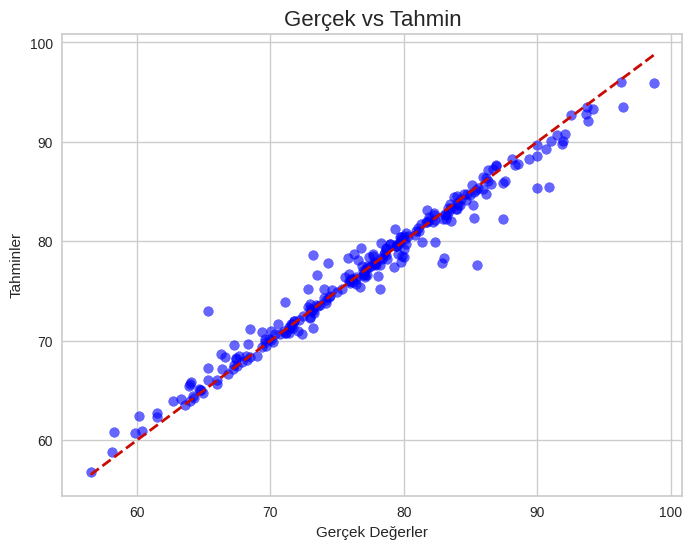

In [257]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Gerçek vs Tahmin', fontsize=16)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.show()

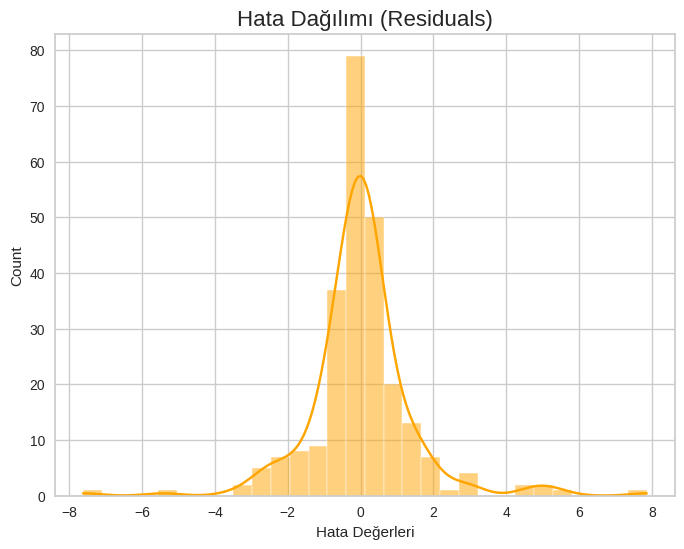

In [258]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Hata Dağılımı (Residuals)", fontsize=16)
plt.xlabel("Hata Değerleri")
plt.show()

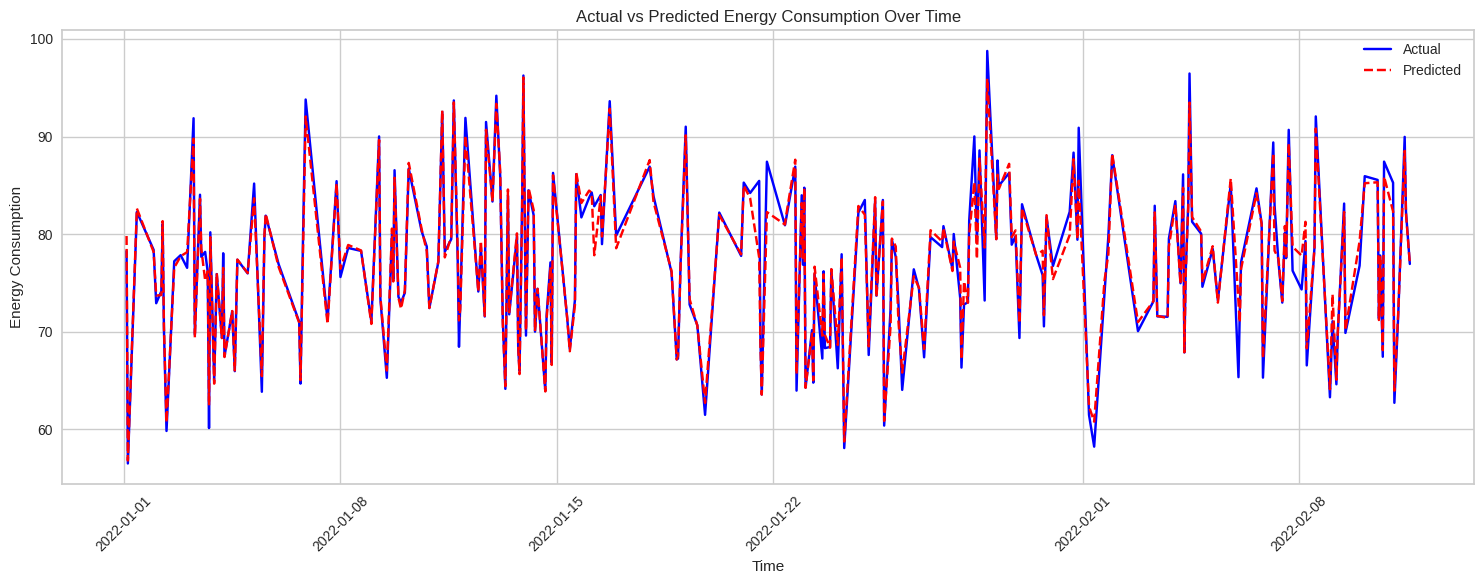

In [259]:
df_test = X_test.copy()
df_test['Actual'] = y_test.values
df_test['Predicted'] = y_pred

df_test['Datetime'] = pd.to_datetime(dict(year=2022,
                                          month=df_test['Month'],
                                          day=df_test['Day'],
                                          hour=df_test['Hour']))
df_test.sort_values('Datetime', inplace=True)
plt.figure(figsize=(15, 6))
plt.plot(df_test['Datetime'], df_test['Actual'], label='Actual', color='blue')
plt.plot(df_test['Datetime'], df_test['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.legend()
plt.tight_layout()
plt.show()

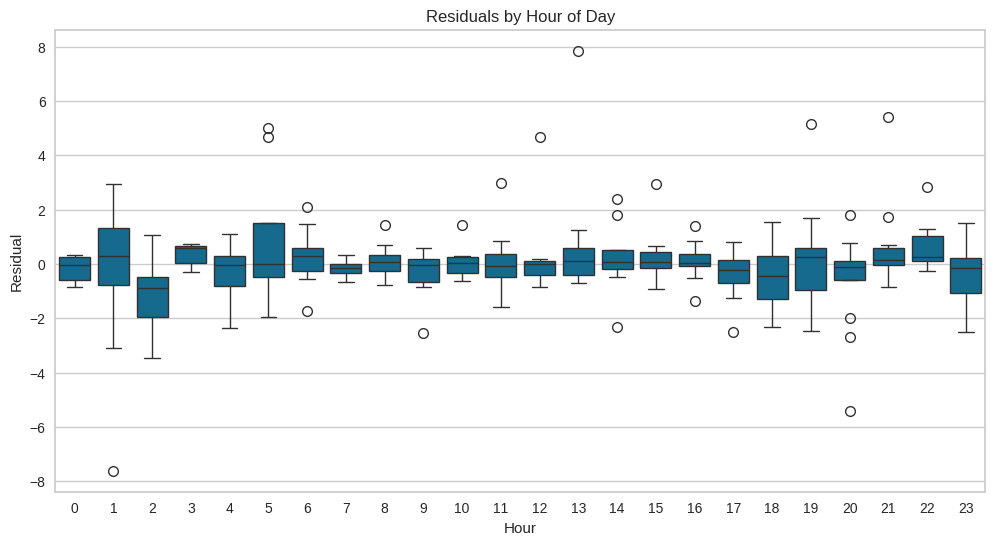

In [260]:
df_test['Residual'] = df_test['Actual'] - df_test['Predicted']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Residual', data=df_test)
plt.title('Residuals by Hour of Day')
plt.show()

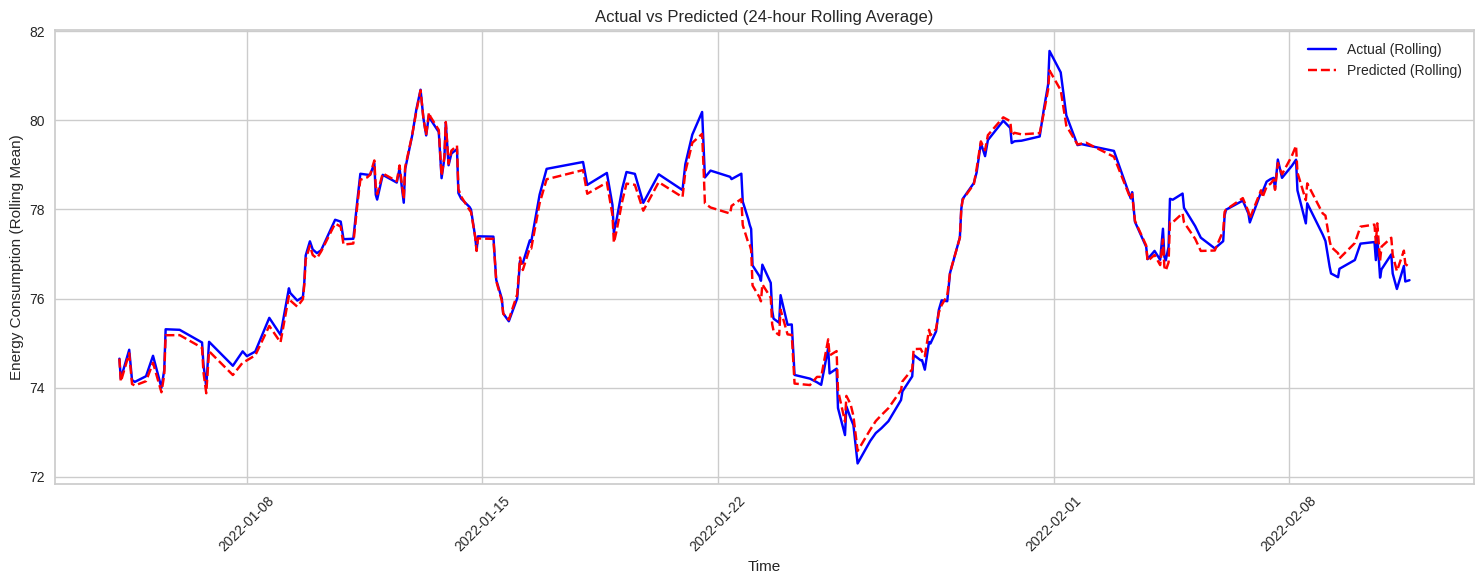

In [261]:
df_test['Actual_Roll'] = df_test['Actual'].rolling(window=24).mean()
df_test['Predicted_Roll'] = df_test['Predicted'].rolling(window=24).mean()

plt.figure(figsize=(15, 6))
plt.plot(df_test['Datetime'], df_test['Actual_Roll'], label='Actual (Rolling)', color='blue')
plt.plot(df_test['Datetime'], df_test['Predicted_Roll'], label='Predicted (Rolling)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (Rolling Mean)')
plt.title('Actual vs Predicted (24-hour Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

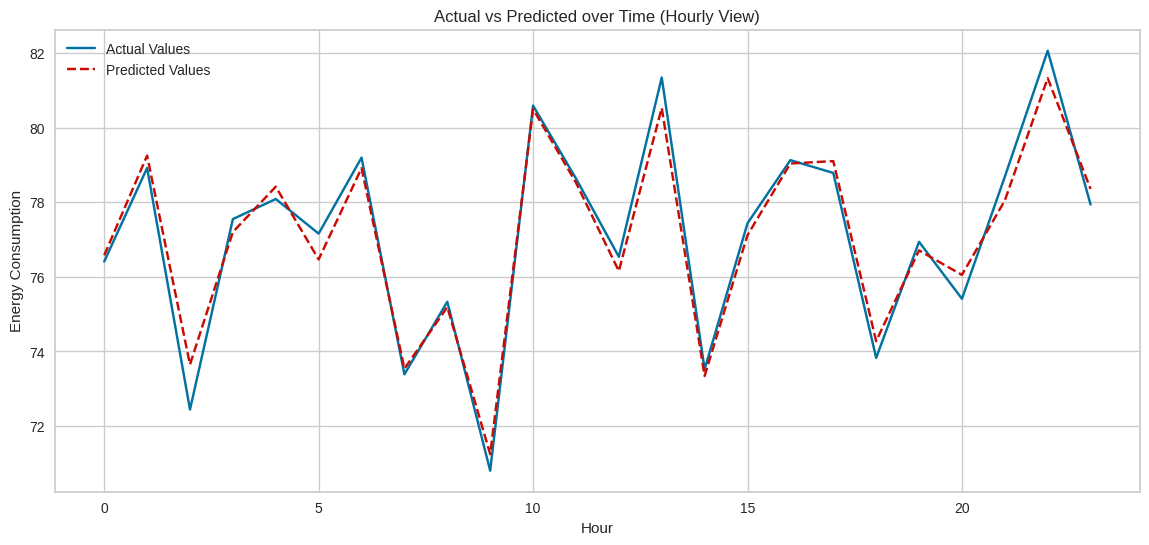

In [262]:
heatmap_data = df_test.groupby('Hour')[['Actual', 'Predicted']].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(x='Hour', y='Actual', data=heatmap_data, label="Actual Values", color="b")
sns.lineplot(x='Hour', y='Predicted', data=heatmap_data, label="Predicted Values", color="r", linestyle="--")
plt.title("Actual vs Predicted over Time (Hourly View)")
plt.xlabel("Hour")
plt.ylabel("Energy Consumption")
plt.legend()
plt.show()

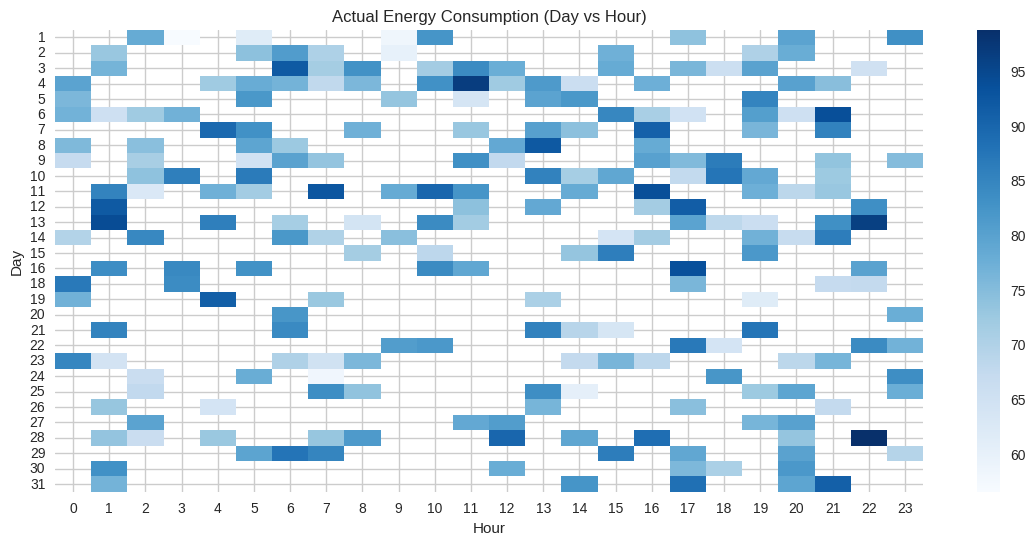

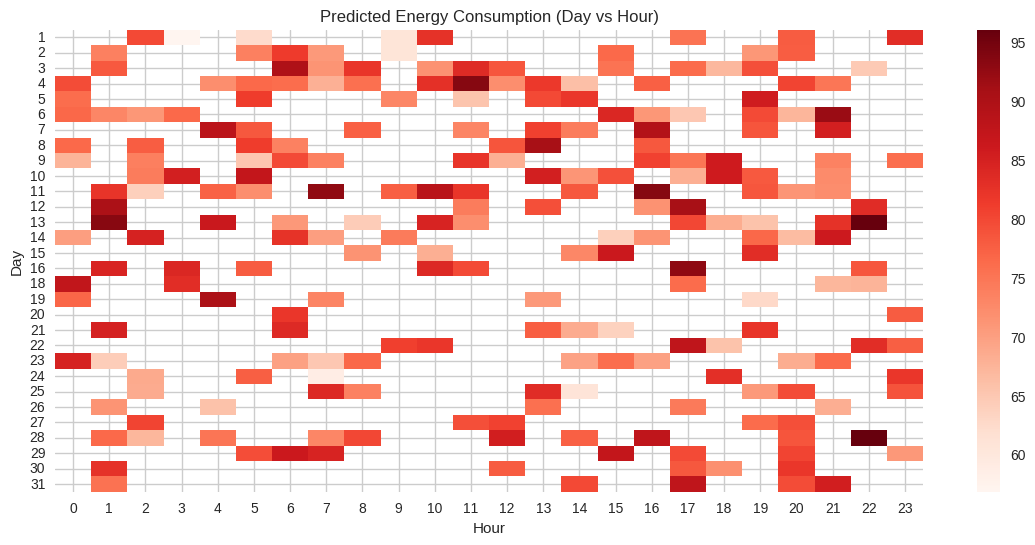

In [263]:
pivot_actual = df_test.pivot_table(index='Day', columns='Hour', values='Actual')
pivot_predicted = df_test.pivot_table(index='Day', columns='Hour', values='Predicted')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_actual, cmap='Blues')
plt.title('Actual Energy Consumption (Day vs Hour)')
plt.show()

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_predicted, cmap='Reds')
plt.title('Predicted Energy Consumption (Day vs Hour)')
plt.show()